In [1]:
import torch
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb 

import torch 
from torch import nn 
from torch import optim
import torch.nn.functional as y 
from torchvision import datasets as d
from torchvision import transforms as t
from torchvision import transforms as t
from torchvision.transforms import Compose as c
from collections import OrderedDict

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# training_data 
# you'll want to apply transformations such as random scaling, cropping, and flipping
# You'll also need to make sure the input data is resized to 224x224 pixels 
training_data =c([
    t.RandomRotation(60),
    t.RandomResizedCrop(224),
    t.RandomHorizontalFlip(),
    t.ToTensor(),
    t.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [5]:
#validation_data 
# but you'll need to resize then crop the images to the appropriate size
valid_data=c([
        t.Resize(255),
        t.CenterCrop(224),
        t.ToTensor(),
        t.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data=c([
        t.Resize(255),
        t.CenterCrop(224),
        t.ToTensor(),
        t.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])



In [6]:
training_dataset=d.ImageFolder(train_dir, transform=training_data)
valid_dataset=d.ImageFolder(valid_dir, transform=valid_data)
test_dataset=d.ImageFolder(test_dir, transform=test_data)

In [7]:
from torch.utils.data import DataLoader as DL
train_loader=DL(training_dataset, batch_size=32, shuffle=True)
validation_loader=DL(valid_dataset,batch_size=32)
test_loader=DL(test_dataset,batch_size=32)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [8]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [25]:
# TODO: Build and train your network
# Load a pre-trained network 
# (If you need a starting point, the VGG networks work great and are straightforward to use)


from torchvision import models 

model = models.vgg11(pretrained=True)

for param in model.parameters():
    param.requires_grad = False



In [26]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
# network archietechure
from collections import OrderedDict
model.classifier=nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(25088,5024)),
    ('relu1',nn.ReLU()),
    ('dropout1',nn.Dropout(p=0.20)),
    ('fc2',nn.Linear(5024,1024)),
    ('relu2',nn.ReLU()),
    ('dropout2',nn.Dropout(p=0.2)),
    ('fc3',nn.Linear(1024,102)),
    ('output',nn.LogSoftmax(dim=1))]))

In [27]:
criterion=nn.NLLLoss()
optimizer=optim.Adam(model.classifier.parameters(),lr=0.001)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kern

In [31]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features

epoch=1
step=0
running_loss=0
print_every=15 

for e in range(epoch):
    for images,labels in train_loader:
        step+=1

        print(step ,end=" ")
        images,labels=images.to(device),labels.to(device)
        optimizer.zero_grad()
        
        logps=model(images)
        
        loss=criterion(logps,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item() 
        
        
        if step % print_every == 0:
            model.eval()
            test_loss=0
            accuracy=0
            for images,labels in validation_loader:
                    images,labels= images.to(device),labels.to(device)
                    logps=model(images)
                    loss=criterion(logps,labels)

                    
                    #acurracy
                    ps= torch.exp(logps)
                    topps,top_class=ps.topk(1,dim=1)
                    equallity=top_class== labels.view(*top_class.shape)
                    accuracy+=torch.mean(equallity.type(torch.cuda.FloatTensor))
            print()        
            print(f"epoch:{e+1}/{epoch}..\t"
              f"training loss:{running_loss/print_every}..\t" 
              f"test loss:{test_loss/len(test_loader)}..\t"
             f"test accuracy:{accuracy/len(test_loader)}")
        
        
        

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
epoch:1/1..	training loss:1.2682984749476114..	test loss:0.0..	test accuracy:0.7011218070983887
16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
epoch:1/1..	training loss:2.5079516053199766..	test loss:0.0..	test accuracy:0.7363782525062561
31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 
epoch:1/1..	training loss:3.6560754934946695..	test loss:0.0..	test accuracy:0.7594819068908691
46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 
epoch:1/1..	training loss:4.871291506290436..	test loss:0.0..	test accuracy:0.7616186141967773
61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 
epoch:1/1..	training loss:5.9844403465588885..	test loss:0.0..	test accuracy:0.7541400194168091
76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 
epoch:1/1..	training loss:7.224625194072724..	test loss:0.0..	test accuracy:0.7793803811073303
91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 
epoch:1/1..	training loss:8.641149246692658..	test loss:0.0..	test accuracy:0.7546741962432861
106 107 108 

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [15]:
# TODO: Do validation on the test set

In [16]:
correct = 0
total = 0
model.to(device)


with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted_outcome = torch.max(outputs.data, 1)
       
        total += labels.size(0)

        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

Test accuracy of model: 85.592%


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
# TODO: Save the checkpoint 
ckpnt={
    'state_dict': model.state_dict(),
    'classifier': model.classifier,
    'class_to_idx':test_dataset.class_to_idx,
    "arch": "vgg11"
}


torch.save(ckpnt,"checkpoint.pth")

In [18]:
ckpnt["arch"]

'vgg11'

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [19]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load(file):
    statedict=torch.load(file)
    model.classifier=statedict['classifier']
    model.load_state_dict (statedict ['state_dict'])
    for param in model.parameters():
            param.requires_grad = False #turning off tuning of the model
    return model            
            
model=load("checkpoint.pth")

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [20]:
from PIL import Image
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    img = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = c([t.Resize(256),
                   t.CenterCrop(224),
                   t.ToTensor(),
                   t.Normalize([0.485, 0.456, 0.406], 
                               [0.229, 0.224, 0.225])]) 
    
    ## Transforming image for use with network
    timg = transform(img)
    
    # Converting to Numpy array 
    return  np.array(timg)


In [21]:
# Test image
image_name =  f'{data_dir }/test/100/image_07896'
img_test =  process_image(image_name)


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

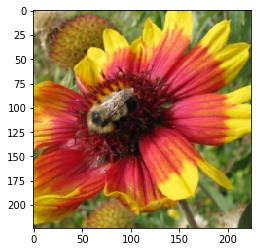

In [22]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
imshow(img_test, ax=None, title=None)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [36]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
 
    img = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    img = torch.from_numpy(img)
    
    img = img.unsqueeze(0)
   
    
    output = model(img)
    
    prob= torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_prob, top_indices = prob.topk(topk)
    
    # Convert to lists
    top_prob = top_prob.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in test_dataset.class_to_idx.items()}
    #print(idx_to_class)
    
    top_class = [idx_to_class[index] for index in top_indices]
    
    return top_prob, top_class

model.to("cpu")
probs, classes = predict('flowers/test/15/image_06369', model)   
print(probs)
print(classes)
    
# TODO: Implement the code to predict the class from an image file

[0.9813109636306763, 0.018358733505010605, 0.0002539348497521132, 2.373079587414395e-05, 1.2588639037858229e-05]
['15', '42', '83', '48', '90']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes

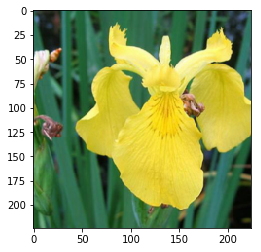

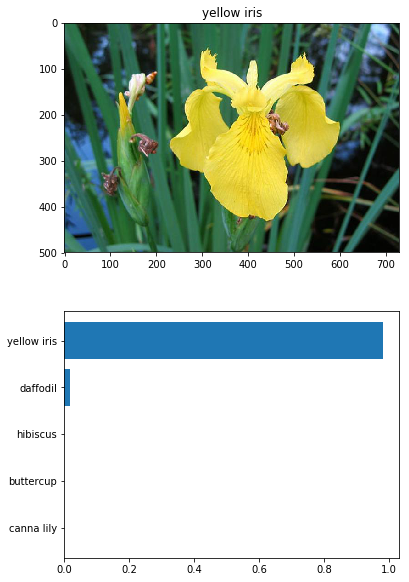

In [40]:
def display_stats( image_path, cat_to_nam):
    # Getting prediction
    probs,classes = predict(image_path, model, topk=5)

    # Uncomment to check if the class of flower (as seen from the file path) matches the top one predicted:
    #print(classes[0])

    # Converting classes to names
    names = []
    for i in classes:
        names += [cat_to_name[i]]

    # Creating PIL image
    image = Image.open(f'{image_path}.jpg')

    # Plotting test image and predicted probabilites
    f, ax = plt.subplots(2,figsize = (6,10))

    ax[0].imshow(image)
    ax[0].set_title(names[0])

    y_names = np.arange(len(names))
    ax[1].barh(y_names, probs)
    ax[1].set_yticks(y_names)
    ax[1].set_yticklabels(names)
    ax[1].invert_yaxis() 

    plt.show()


# Uncomment below to see the transformed image on which the model based its prediction
imshow(process_image('flowers/test/15/image_06369'), ax=None, title=None)
display_stats('flowers/test/15/image_06369', cat_to_name)